<center><h1> Atividade 10</h1></center>

Utilizar o conjunto de dados weatherHistory.csv, que contém o histórico de variáveis relacionadas ao clima da cidade de Szede, Hungria, entre 2006 e 2016.

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
weather = pd.read_csv('weatherHistory.csv', low_memory=False)
weather['Precip Type'] = weather['Precip Type'].fillna('Others')
weather.head(3)

Formatted Date        Summary Precip Type  Temperature (C)  \
0  2006-04-01 00:00:00.000 +0200  Partly Cloudy        rain         9.472222   
1  2006-04-01 01:00:00.000 +0200  Partly Cloudy        rain         9.355556   
2  2006-04-01 02:00:00.000 +0200  Mostly Cloudy        rain         9.377778   

   Apparent Temperature (C)  Humidity  Wind Speed (km/h)  \
0                  7.388889      0.89            14.1197   
1                  7.227778      0.86            14.2646   
2                  9.377778      0.89             3.9284   

   Wind Bearing (degrees)  Visibility (km)  Loud Cover  Pressure (millibars)  \
0                   251.0          15.8263         0.0               1015.13   
1                   259.0          15.8263         0.0               1015.63   
2                   204.0          14.9569         0.0               1015.94   

                       Daily Summary  
0  Partly cloudy throughout the day.  
1  Partly cloudy throughout the day.  
2  Partly cloudy throughout the day.

In [3]:
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

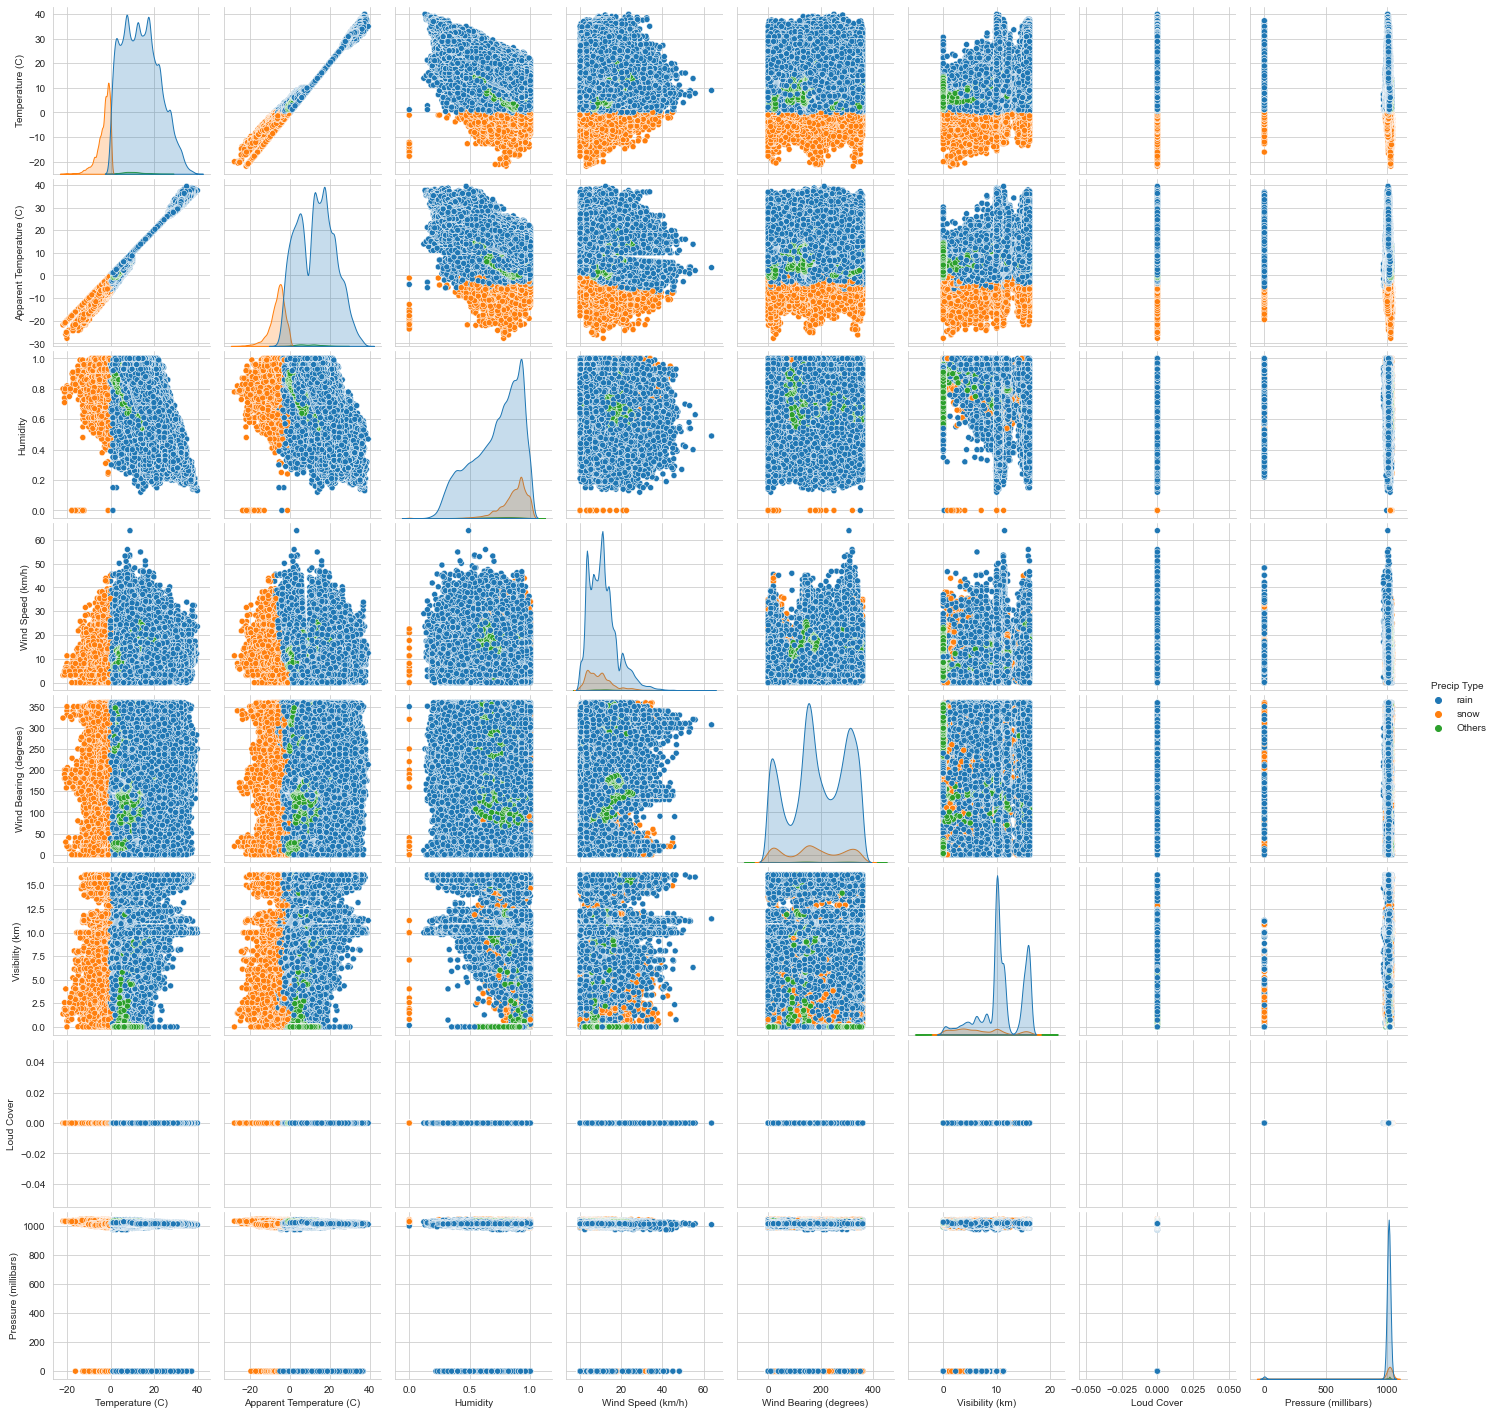

In [4]:
sns.pairplot(weather, hue='Precip Type')
plt.show()

## 1. Utilize o K-means para separar os dados em grupos distintos, desconsiderando o tipo de precipitação.

In [5]:
from sklearn.cluster import KMeans

In [6]:
precip_type = weather['Precip Type']
weather=weather[['Temperature (C)', 'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover', 'Pressure (millibars)']]
precip_type.value_counts()

rain      85224
snow      10712
Others      517
Name: Precip Type, dtype: int64

In [7]:
kmeans = KMeans(n_clusters=3).fit(weather)

## 2. Veja se é possível associar cada grupo gerado pelo K-Means a um tipo de precipitação diferente, olhando para o tipo de precipitação real.

In [15]:
def print_labels(model, weather, precip_type):
    plt.figure(figsize=(10,3))

    #Real
    plt.subplot(1,2,1)
    sns.scatterplot(x=weather['Temperature (C)'], y=weather['Humidity'], hue=precip_type, s=40)
    plt.title('Classificação Real')

    #K-Means
    plt.subplot(1,2,2)
    sns.scatterplot(x=weather['Temperature (C)'], y=weather['Humidity'], hue=model.labels_, s=40)
    plt.title('Classificação K-Means') 
    
    plt.show()

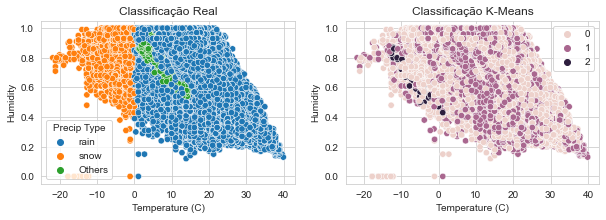

In [16]:
print_labels(kmeans, weather, precip_type)

Olhando para o gráfico acima, podemos perceber que a label 0, retornada pelo K-Means tem mais afinidade com a label Others original, assim como os pares 1-rain e 2-snow. Entretanto, vamos analisar as métricas do resultado obtido para uma análise mais precisa.

In [17]:
from sklearn.metrics import classification_report

In [18]:
y_pred = pd.Series(kmeans.labels_).replace({0:'Others', 1:'rain', 2:'snow'})
print(classification_report(precip_type, y_pred))

              precision    recall  f1-score   support

      Others       0.01      0.57      0.01       517
        rain       0.90      0.46      0.60     85224
        snow       0.14      0.02      0.03     10712

    accuracy                           0.41     96453
   macro avg       0.35      0.35      0.22     96453
weighted avg       0.81      0.41      0.54     96453



Com base nas métricas plotadas, vemos que apenas a label 'rain' possui resultados interessantes. Portanto temos de verificar se alguma feature está atrapalhando o algoritmo.

## 3. Faça testes com diferentes atributos para verificar se existe alguns sub-conjuntos de atributos mais adequados para agrupar esses dados. Utilize o cálculo da silhueta para verificar a qualidade dos grupos obtidos. É possível observar que o coeficiente de silhueta está associado a um melhor agrupamento, ao se comparar com os dados reais?

In [20]:
from sklearn import metrics

Primeiramente, vamos calcular o resultado da silhueta para o modelo com todas as features:

In [21]:
print('Silhueta:', round(metrics.silhouette_score(weather, kmeans.labels_), 4))

Silhueta: 0.5867


Quanto às outras features, vamos usar a correlação de Pearson para identificar aquelas que podem ser mais associadas à precipitação:

In [22]:
#Adicionando a label ao dataset original para calcular
#para cálculo da correlação
weather_precip = weather.copy()
weather_precip['Precip Type'] = precip_type.replace(['Others', 'rain', 'snow'], [0,1,2])

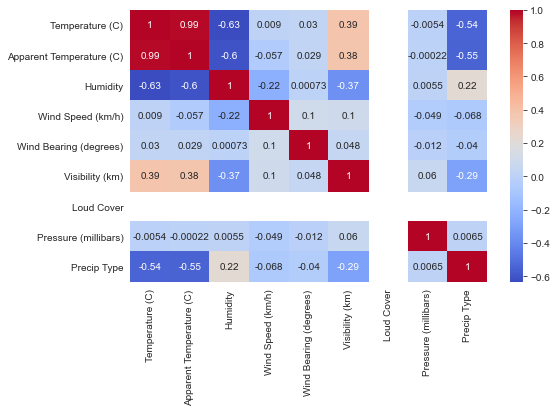

In [24]:
#Usando a correlação de Pearson
plt.figure(figsize=(8,5))
corr = weather_precip.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

Vamos manter somente as features com maior correlação com o tipo de precipitação: Temperatura, Temperatura aparente, Humidade e Visibilidade. Entretanto, se duas fetures forem muito correlacionadas entre si, podemos manter somente uma delas. É o que acontece com as features Temperatura e Temperatura aparente, que possuem correlação de 99%. Por isso, vamos manter somente a feature Temperatura Aparente, pois esta possui maior correlação com o tipo de precipitação.

In [25]:
#Gerar todas as combinações possíveis para analisar o
#comportamento dos modelos
import itertools

def get_combinations(values):
    comb=[]
    
    for i in range(2, len(values)+1):
        comb_with_i_values = [list(v) for v in itertools.combinations(values, i)]
        comb.extend(comb_with_i_values)
        
    return comb

Vamos gerar um modelo para cada conjunto de features possível e analisar o valor da silhueta.

Features: Apparent Temperature (C), Humidity
Gráficos


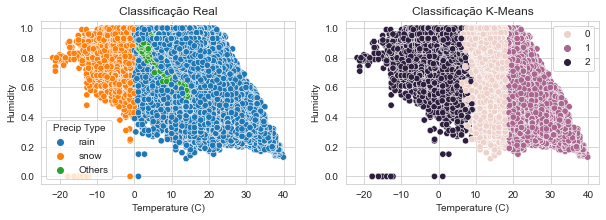

Silhueta: 0.0097 


Features: Apparent Temperature (C), Visibility (km)
Gráficos


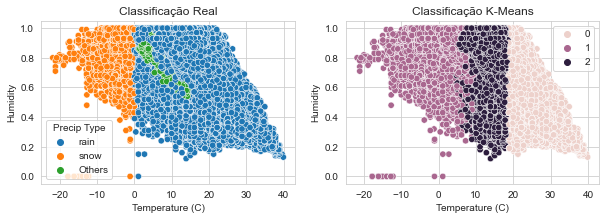

Silhueta: 0.0069 


Features: Apparent Temperature (C), Wind Speed (km/h)
Gráficos


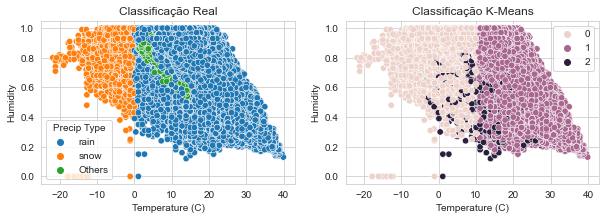

Silhueta: 0.0061 


Features: Apparent Temperature (C), Wind Bearing (degrees)
Gráficos


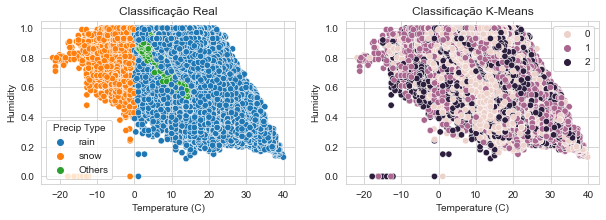

Silhueta: 0.5394 


Features: Humidity, Visibility (km)
Gráficos


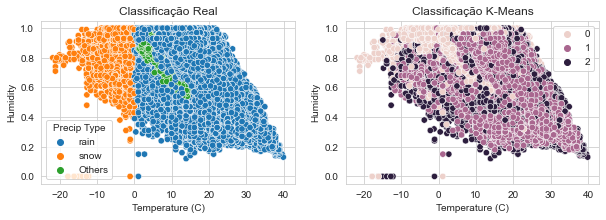

Silhueta: -0.0488 


Features: Humidity, Wind Speed (km/h)
Gráficos


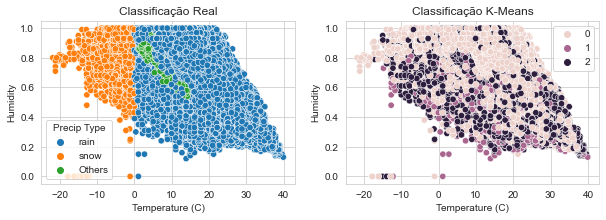

Silhueta: -0.0199 


Features: Humidity, Wind Bearing (degrees)
Gráficos


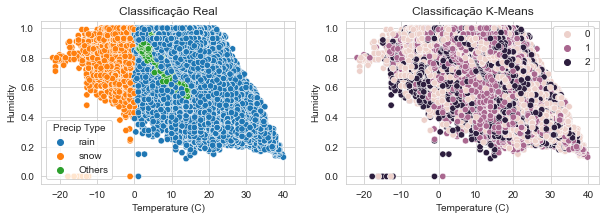

Silhueta: 0.539 


Features: Visibility (km), Wind Speed (km/h)
Gráficos


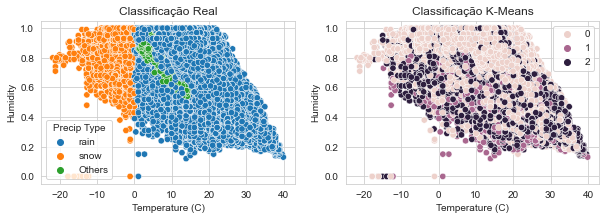

Silhueta: -0.0201 


Features: Visibility (km), Wind Bearing (degrees)
Gráficos


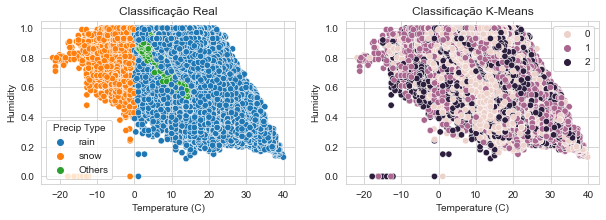

Silhueta: 0.5394 


Features: Wind Speed (km/h), Wind Bearing (degrees)
Gráficos


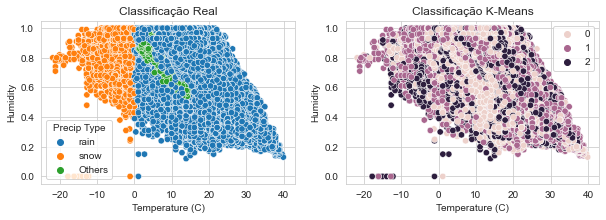

Silhueta: 0.539 


Features: Apparent Temperature (C), Humidity, Visibility (km)
Gráficos


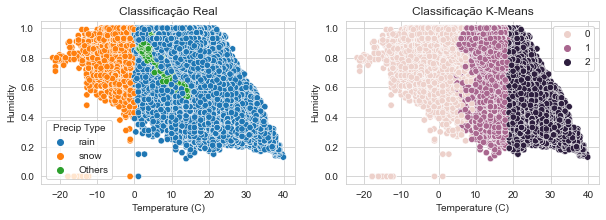

Silhueta: 0.007 


Features: Apparent Temperature (C), Humidity, Wind Speed (km/h)
Gráficos


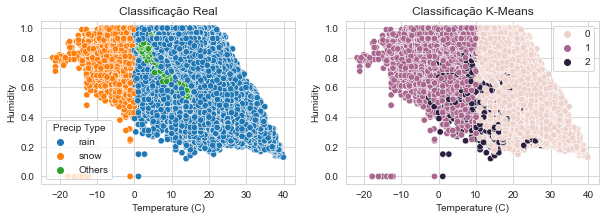

Silhueta: 0.0058 


Features: Apparent Temperature (C), Humidity, Wind Bearing (degrees)
Gráficos


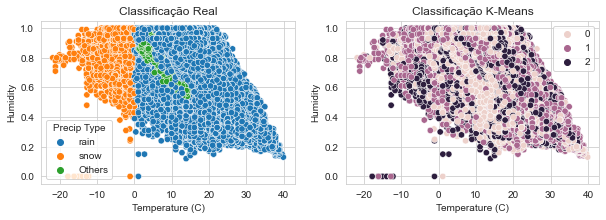

Silhueta: 0.539 


Features: Apparent Temperature (C), Visibility (km), Wind Speed (km/h)
Gráficos


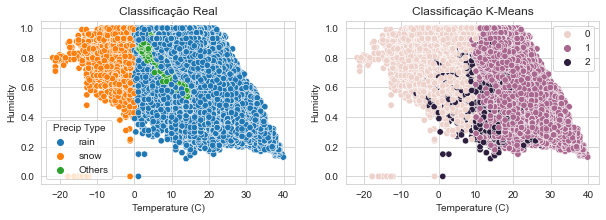

Silhueta: 0.0059 


Features: Apparent Temperature (C), Visibility (km), Wind Bearing (degrees)
Gráficos


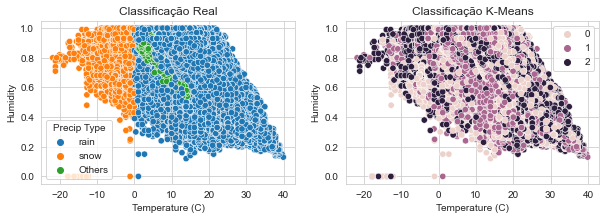

Silhueta: 0.5395 


Features: Apparent Temperature (C), Wind Speed (km/h), Wind Bearing (degrees)
Gráficos


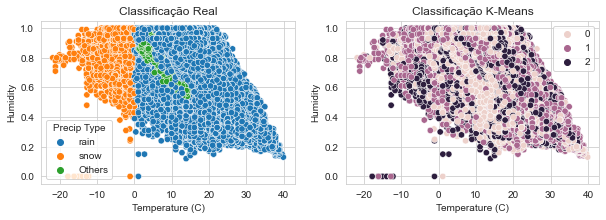

Silhueta: 0.539 


Features: Humidity, Visibility (km), Wind Speed (km/h)
Gráficos


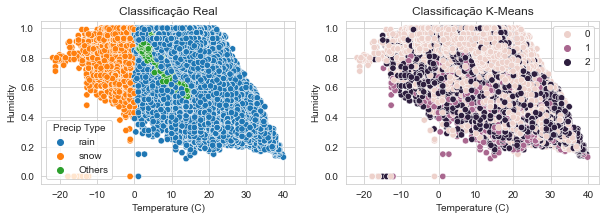

Silhueta: -0.02 


Features: Humidity, Visibility (km), Wind Bearing (degrees)
Gráficos


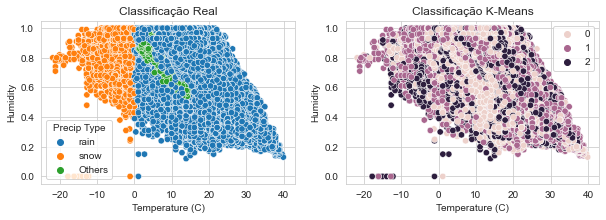

Silhueta: 0.539 


Features: Humidity, Wind Speed (km/h), Wind Bearing (degrees)
Gráficos


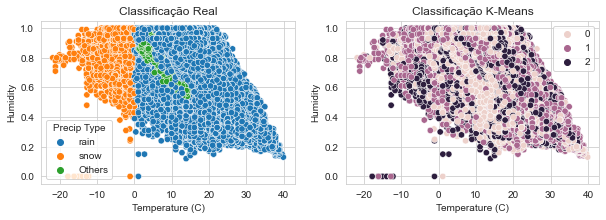

Silhueta: 0.539 


Features: Visibility (km), Wind Speed (km/h), Wind Bearing (degrees)
Gráficos


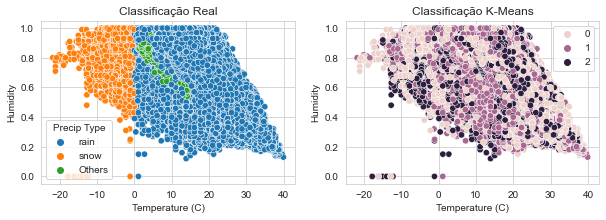

Silhueta: 0.538 


Features: Apparent Temperature (C), Humidity, Visibility (km), Wind Speed (km/h)
Gráficos


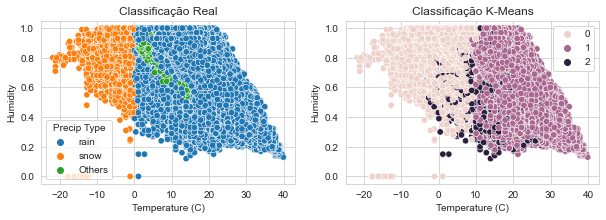

Silhueta: 0.0044 


Features: Apparent Temperature (C), Humidity, Visibility (km), Wind Bearing (degrees)
Gráficos


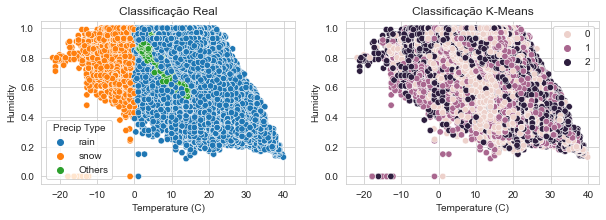

Silhueta: 0.538 


Features: Apparent Temperature (C), Humidity, Wind Speed (km/h), Wind Bearing (degrees)
Gráficos


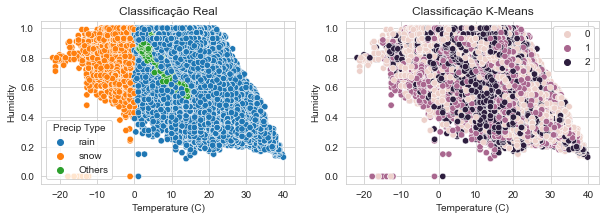

Silhueta: 0.538 


Features: Apparent Temperature (C), Visibility (km), Wind Speed (km/h), Wind Bearing (degrees)
Gráficos


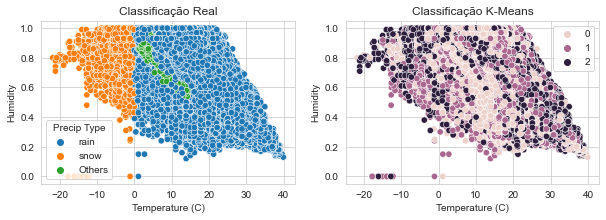

Silhueta: 0.539 


Features: Humidity, Visibility (km), Wind Speed (km/h), Wind Bearing (degrees)
Gráficos


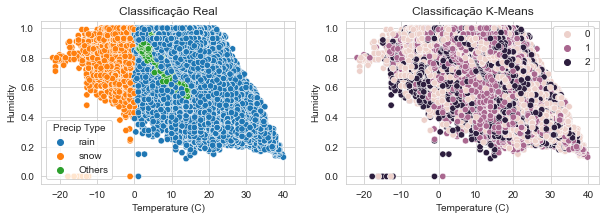

Silhueta: 0.539 


Features: Apparent Temperature (C), Humidity, Visibility (km), Wind Speed (km/h), Wind Bearing (degrees)
Gráficos


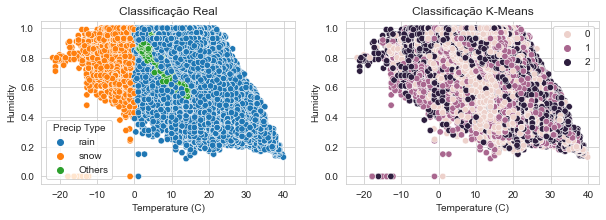

Silhueta: 0.538 




In [26]:
for features in get_combinations(['Apparent Temperature (C)', 'Humidity', 'Visibility (km)', 'Wind Speed (km/h)', 'Wind Bearing (degrees)']):
    print('Features: ', end='')
    print(*features, sep=', ')
    
    kmeans = KMeans(n_clusters=3).fit(weather[features])
    print('Gráficos')
    print_labels(kmeans, weather, precip_type)
    print('Silhueta:', round(metrics.silhouette_score(weather, kmeans.labels_), 4), '\n\n')
    

Com base nos gráficos apresentados acima, e seus respectivos valores de silhueta, podemos notar que um agrupamento com maior valor de silhueta tende a apresentar mais dados classificados corretamente. Entretanto, isso não significa que os grupos estarão bem divididos, do ponto de vista da distância entre os grupos (intracluster).

Por outro lado, os resultados encontrados para modelos com um número menor de features não alcançaram os do modelo completo. Esta situação pode ser explicada pelo baixo número de dimensões já que, como temos poucas features, mesmo uma baixa correlação ainda impacta na identificação do grupo.